In [1]:
import torch
from torch import nn
import selfies as sf
import sys, os
from rdkit import Chem
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score.sascorer import calculateScore
# Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Print torch version
print(torch.__version__)

2.3.0.post301


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
device

device(type='cuda')

In [3]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
# read in all the smiles
smiles = open('data/1to6.dmu.smi', 'r').read().splitlines()
smiles_sf = open('data/1to6.dmu.selfies', 'r').read().splitlines()
print(len(smiles), len(smiles_sf))
print(max(len(w) for w in smiles_sf))
print(smiles_sf[-8:])

35466 35466
120
['[N][C][C][C][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[N][C][C][N][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[O][C][C][C][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[O][C][C][N][C][Ring1][Ring2][Ring1][Ring1][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][C][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][N][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[N][C][N][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]', '[C][C][C][Ring1][Ring1][C][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][C][Ring1][Branch1][Ring1][Ring2][Ring1][Ring1]']


[7.3284153846153846, 6.667815384615385, 5.868476923076923, 4.780644842026316, 4.025844842026315, 4.107167918949392, 4.08999868818016, 4.492506380487854, 4.043614072795545, 5.355860226641699]


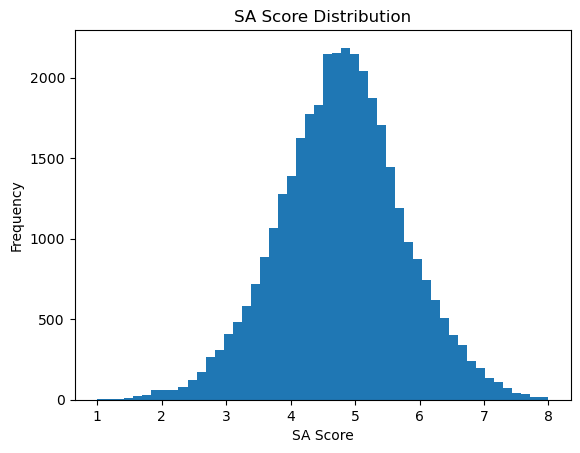

In [4]:
# Compute the SAS score for all the smiles
sasScores = [calculateScore(Chem.MolFromSmiles(s)) for s in smiles]
print(sasScores[:10])

# Plot the SAS score distribution
import matplotlib.pyplot as plt
plt.hist(sasScores, bins=50)
plt.xlabel('SA Score')
plt.ylabel('Frequency')
plt.title('SA Score Distribution')
plt.show()

 Proportion of SAS scores between 0 and 1.5: 0.00042


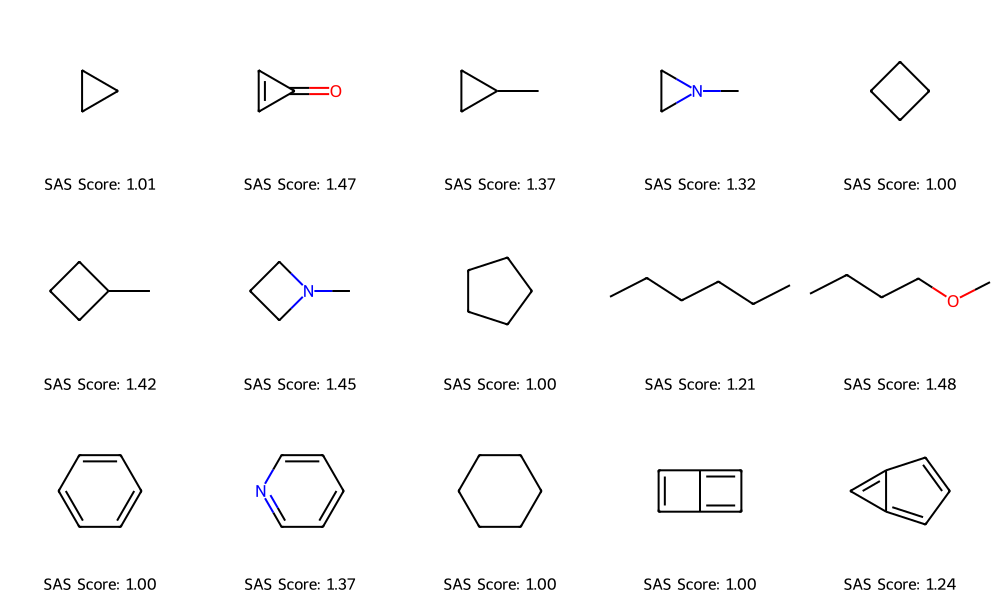

In [8]:
# Count the number of smiles with SAS score between min and max
min = 0
max = 1.5
count = 0
for score in sasScores:
    if score > min and score < max:
        count += 1  
print(f" Proportion of SAS scores between {min} and {max}: {count/len(sasScores):.5f}")

# Draw the corresponding molecules
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(s) for s in smiles if calculateScore(Chem.MolFromSmiles(s)) > min and calculateScore(Chem.MolFromSmiles(s)) < max]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=[f'SAS Score: {calculateScore(mol):.2f}' for mol in mols])

In [9]:
# Normalize the SAS scores from 0 to 1 using scikit-learn   
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
norm_sasScores = scaler.fit_transform(torch.tensor(sasScores).reshape(-1, 1)).reshape(-1)
print(norm_sasScores[:10])
print(scaler.inverse_transform(norm_sasScores[:10].reshape(-1, 1)).reshape(-1))

[0.90436034 0.80995747 0.69572826 0.54027195 0.4324075  0.44402889
 0.44157536 0.49909562 0.43494675 0.62247293]
[7.32841539 6.66781521 5.86847687 4.78064489 4.02584505 4.10716772
 4.08999872 4.4925065  4.04361391 5.35586023]


In [10]:
import numpy as np

def rbf_kernel(input_value: float, dimension: int, gamma: float = 1.0) -> torch.Tensor:
    """
    Compute the RBF (Radial Basis Function) kernel for a given input.

    Parameters:
    input_value (float): The input scalar value.
    dimension (int): The dimension of the output vector.
    gamma (float): The gamma parameter for the RBF kernel. Default is 1.0.

    Returns:
    np.ndarray: A vector of the specified dimension with the RBF kernel applied.
    """
    # Create an array of evenly spaced points between 0 and 1
    points = torch.linspace(0, 1, dimension)
    
    # Compute the RBF kernel
    rbf_vector = torch.exp(-gamma * (points - input_value)**2)
    
    return rbf_vector

# Example usage
input_value = 0.4
dimension = 5
gamma = 0.5
rbf_vector = rbf_kernel(input_value, dimension, gamma)
print(rbf_vector)

tensor([0.9231, 0.9888, 0.9950, 0.9406, 0.8353])


In [11]:
# Convert normalized SAS scores to RBF kernel
COND_DIM = 5
sas_rbf = torch.stack([rbf_kernel(s, COND_DIM) for s in norm_sasScores])
print(sas_rbf.shape, sas_rbf[0])

torch.Size([35466, 5]) tensor([0.4414, 0.6517, 0.8492, 0.9765, 0.9909])


In [12]:
# build the vocabulary of selfies tokens and mappings to/from integers
alphabet = sf.get_alphabet_from_selfies(smiles_sf)
#chars = sorted(list(set(''.join(smiles))))
stoi = {s:i+1 for i,s in enumerate(alphabet)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
VOCAB_SIZE = len(itos)
print(itos)
print(VOCAB_SIZE)

{1: '[Ring2]', 2: '[Ring1]', 3: '[=O]', 4: '[=N]', 5: '[=C]', 6: '[#N]', 7: '[O]', 8: '[Branch1]', 9: '[=Branch1]', 10: '[C]', 11: '[N]', 12: '[=Ring1]', 13: '[#C]', 0: '.'}
14


In [70]:
# shuffle the smiles
#import random
#random.seed(42)
#random.shuffle(smiles_sf)

In [13]:
SEQ_LEN = 128   # maximum length of a SELFIES string
EMB_DIM = 20
LAT_DIM = 10

# build the dataset
def build_dataset(smiles_sf):
    X = []
    for s in smiles_sf:
        x = []
        for vocab in list(sf.split_selfies(s)) + ['.']:
            ix = stoi[vocab]
            x.append(ix)
        while len(x) < SEQ_LEN:
            x.append(0)
        X.append(x)
    X = torch.tensor(X)
    print(X.shape)
    return X
n1 = int(0.8 * len(smiles_sf))
n2 = int(0.9 * len(smiles_sf))
Xtr = build_dataset(smiles_sf[:n1])
Xdev = build_dataset(smiles_sf[n1:n2])
Xte = build_dataset(smiles_sf[n2:])

Ctr = sas_rbf[:n1]
Cdev = sas_rbf[n1:n2]
Cte = sas_rbf[n2:]

print(Ctr.shape, Cdev.shape, Cte.shape)

torch.Size([28372, 128])
torch.Size([3547, 128])
torch.Size([3547, 128])
torch.Size([28372, 5]) torch.Size([3547, 5]) torch.Size([3547, 5])


In [14]:
for x in Xtr[-20:]:
    print(''.join(itos[ix.item()] for ix in x), '-->', x.tolist())

[C][=C][C][O][C][N][Ring1][Branch1][Ring1][Ring2]...................................................................................................................... --> [10, 5, 10, 7, 10, 11, 2, 8, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[C][=C][C][O][N][N][Ring1][Branch1][Ring1][Ring2]...................................................................................................................... --> [10, 5, 10, 7, 11, 11, 2, 8, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [15]:
from torch.utils.data import DataLoader, Dataset
# Define the dataset class
class SelfiesDataset(Dataset):
    def __init__(self, input_list, condition_list):
        self.input_list = input_list
        self.condition_list = condition_list

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self, idx):
        return self.input_list[idx], self.condition_list[idx]

# Improved Variational Autoencoder model with GRU
class CVAE_selfies(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, hidden_dim=100, latent_dim=LAT_DIM, cond_dim=COND_DIM):
        super().__init__()
                
        # Encoder
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn_emb2hid = nn.GRU(emb_dim + cond_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2, bidirectional=True)
        self.fc_hid2mean = nn.Linear(hidden_dim * 2 * 2, latent_dim)  # Multiply by 2 due to bidirection, 2 again due to num_layers
        self.fc_hid2logvar = nn.Linear(hidden_dim * 2 * 2, latent_dim)
        
        # Decoder
        self.fc_lat2hid = nn.Linear(latent_dim + cond_dim, hidden_dim * 2)  # Adjusted for num_layers
        self.rnn_hid2emb = nn.GRU(emb_dim + cond_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2)
        self.fc_emb2out = nn.Linear(hidden_dim, vocab_size)
    
    def encode(self, x, c):
        c_expanded = c.unsqueeze(1).expand(-1, x.size(1), -1)  # Expand the conditional tensor to match the input size
        x = self.emb(x)  # (batch_size, seq_len, emb_dim)
        x_cond = torch.cat([x, c_expanded], dim=-1)  # (batch_size, seq_len, emb_dim + cond_dim)
        _, hn_e = self.rnn_emb2hid(x_cond)  # (num_layers * num_directions, batch, hidden_size)
        hn_e = hn_e.view(hn_e.size(1), -1)  # (batch, hidden_size * num_directions * num_layers) 
        mean = self.fc_hid2mean(hn_e) # (batch, latent_dim)
        logvar = self.fc_hid2logvar(hn_e) # (batch, latent_dim)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar)
        z = mean + torch.exp(0.5 * logvar) * epsilon  # Adjusted to ensure logvar is non-negative
        return z
    
    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=-1)  # (batch, latent_dim + cond_dim)
        hn_d = self.fc_lat2hid(z_cond)  # (batch, hidden_size * num_layers)
        hn_d = hn_d.view(2, z.size(0), -1)  
        c_expanded = c.unsqueeze(1).expand(-1, SEQ_LEN, -1)  # Expand the conditional tensor to match the input size
        h0 = torch.zeros(z.size(0), SEQ_LEN, EMB_DIM).to(device)
        h0_cond = torch.cat([h0, c_expanded], dim=-1)  # (batch, seq_len, emb_dim + cond_dim)
        z, _ = self.rnn_hid2emb(h0_cond, hn_d)
        x_hat = self.fc_emb2out(z)
        return x_hat
    
    def forward(self, x, c):
        mean, logvar = self.encode(x, c)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z, c)
        return x_hat, mean, logvar

# Improved Loss function with KLD annealing
def loss_function(x, x_hat, mean, log_var, beta=1.0):
    reproduction_loss = nn.functional.cross_entropy(x_hat, x, reduction='sum') / x.size(0)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0)
    return reproduction_loss + beta * KLD

In [17]:
batch_size = 64
Xb = torch.randint(0,VOCAB_SIZE,(batch_size,SEQ_LEN)).to(device)
print(Xb.shape)
Cb = torch.randn(batch_size, 5).to(device)
print(Cb.shape)
model = CVAE_selfies().to(device)
x, mean, logvar = model(Xb, Cb)
total_params = sum(p.numel() for p in model.parameters())
print(x.shape, total_params)

torch.Size([64, 128])
torch.Size([64, 5])
torch.Size([64, 128, 14]) 369014


In [18]:
dataset = SelfiesDataset(Xtr, Ctr)

model = CVAE_selfies().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
epochs = 110
batch_size = 64
lossi = []
for epoch in range(epochs):
    model.train()
    for x, c in DataLoader(dataset, batch_size=batch_size, shuffle=True):
        x, c = x.to(device), c.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x, c)
        loss = loss_function(x.view(-1), x_hat.view(-1, VOCAB_SIZE), mean, log_var)
        lossi.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print("\tEpoch", epoch, "\tLoss: ", loss.item())
        
    modelName = 'CVAE_selfies'
    if epoch % 50 == 0 and epoch > 0:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'iteration': epoch
        }
        torch.save(checkpoint, f'models/{modelName}_checkpoint_{epoch}.pt')
        print(f'Checkpoint saved at iteration {epoch}')
    if epoch > 50:
        lr = 1e-4
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


/home/hieu/miniconda3/envs/mlmat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


	Epoch 0 	Loss:  0.13801155984401703
	Epoch 10 	Loss:  0.1357731968164444
	Epoch 20 	Loss:  0.13783375918865204
	Epoch 30 	Loss:  0.12369070947170258
	Epoch 40 	Loss:  0.12286356836557388
	Epoch 50 	Loss:  0.11498664319515228
Checkpoint saved at iteration 50
	Epoch 60 	Loss:  0.11963871866464615
	Epoch 70 	Loss:  0.11706797033548355
	Epoch 80 	Loss:  0.11841642111539841
	Epoch 90 	Loss:  0.12497369199991226
	Epoch 100 	Loss:  0.1306195706129074
Checkpoint saved at iteration 100


In [19]:
from rdkit import Chem
model = CVAE_selfies().to(device)
checkpoint = torch.load('models/CVAE_selfies_checkpoint_100.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
latent_dim = LAT_DIM
def generate_selfies(z, c, temperature=1.0):
    z_sample = torch.tensor([z], dtype=torch.float).to(device)
    c_sample = torch.tensor([c], dtype=torch.float).to(device)
    logits = model.decode(z_sample, c_sample)
    logits = logits.view(-1, VOCAB_SIZE)
    # Apply temperature
    logits = logits / temperature
    prob = nn.functional.softmax(logits, dim=1)
    indices = torch.multinomial(prob, num_samples=1).squeeze(-1)
    return ''.join(itos[ix.item()] for ix in indices).replace('.','')
samp = torch.randn(latent_dim)
cond = torch.tensor(5.0)
cond_sas = scaler.transform(cond.reshape(-1, 1)).reshape(-1)
cond_rfb = rbf_kernel(cond_sas, COND_DIM)
gen_selfies = generate_selfies(samp.tolist(), cond_rfb.tolist())
print(gen_selfies)
gen_smiles = sf.decoder(gen_selfies)
print(gen_smiles, Chem.MolToSmiles(Chem.MolFromSmiles(gen_smiles)))
print('SAS:', calculateScore(Chem.MolFromSmiles(gen_smiles)))

[C][N][N][N][=C][=N][N]
CNNN=C=NN CNNN=C=NN
SAS: 5.437325610815575


In [30]:
# Generate molecules until we find N unique SMILES satisfying the SAS score between min and max
min = 0.5
max = 1.5
unique_smiles = []
n_tries = 0
count = 0
while len(unique_smiles) < 20:
    n_tries += 1
    samp = torch.randn(latent_dim)
    cond = torch.tensor(1.0)
    cond_sas = scaler.transform(cond.reshape(-1, 1)).reshape(-1)
    cond_rfb = rbf_kernel(cond_sas, COND_DIM)
    gen_selfies = generate_selfies(samp.tolist(), 
                                   cond_rfb.tolist(), 
                                   temperature=1.5)
    gen_smiles = sf.decoder(gen_selfies)
    canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(gen_smiles))
    sas_score = calculateScore(Chem.MolFromSmiles(canon_smiles))
    if min < sas_score < max:
        if canon_smiles not in unique_smiles:
            count += 1
            print(f"SMILES {count}: {canon_smiles} SAS: {sas_score:.2f}")
            unique_smiles.append(canon_smiles)
        
print(f" Found {len(unique_smiles)} unique SMILES in {n_tries} tries")
print(f" Probability of finding a valid SMILES: {15/ n_tries:.5f}")


SMILES 1: CC1CC1 SAS: 1.37
SMILES 2: C1CCC1 SAS: 1.00
SMILES 3: C1CC1 SAS: 1.01
SMILES 4: O=c1cc1 SAS: 1.47
SMILES 5: CN1CC1 SAS: 1.32
SMILES 6: C1CCCCC1 SAS: 1.00
SMILES 7: CC1CCC1 SAS: 1.42
SMILES 8: C1CCCC1 SAS: 1.00
SMILES 9: CCCCCC SAS: 1.21
SMILES 10: CCCCOC SAS: 1.48
SMILES 11: CCCCCCC SAS: 1.26
SMILES 12: C1CCCCCC1 SAS: 1.00
SMILES 13: CN1CCC1 SAS: 1.45
SMILES 14: CCCCCCOC SAS: 1.48
SMILES 15: CCCCCOC SAS: 1.47
SMILES 16: CCCCCCCC SAS: 1.30
SMILES 17: c1ccccc1 SAS: 1.00
SMILES 18: c1ccncc1 SAS: 1.37
SMILES 19: CCCCC(=O)O SAS: 1.49
SMILES 20: CCCCCCCCC SAS: 1.26
 Found 20 unique SMILES in 267386 tries
 Probability of finding a valid SMILES: 0.00006


* How can make the generation of desired SMILES faster?

['CC1CC1', 'C1CCC1', 'C1CC1', 'O=c1cc1', 'CN1CC1', 'C1CCCCC1', 'CC1CCC1', 'C1CCCC1', 'CCCCCC', 'CCCCOC', 'CCCCCCC', 'C1CCCCCC1', 'CN1CCC1', 'CCCCCCOC', 'CCCCCOC', 'CCCCCCCC', 'c1ccccc1', 'c1ccncc1', 'CCCCC(=O)O', 'CCCCCCCCC']


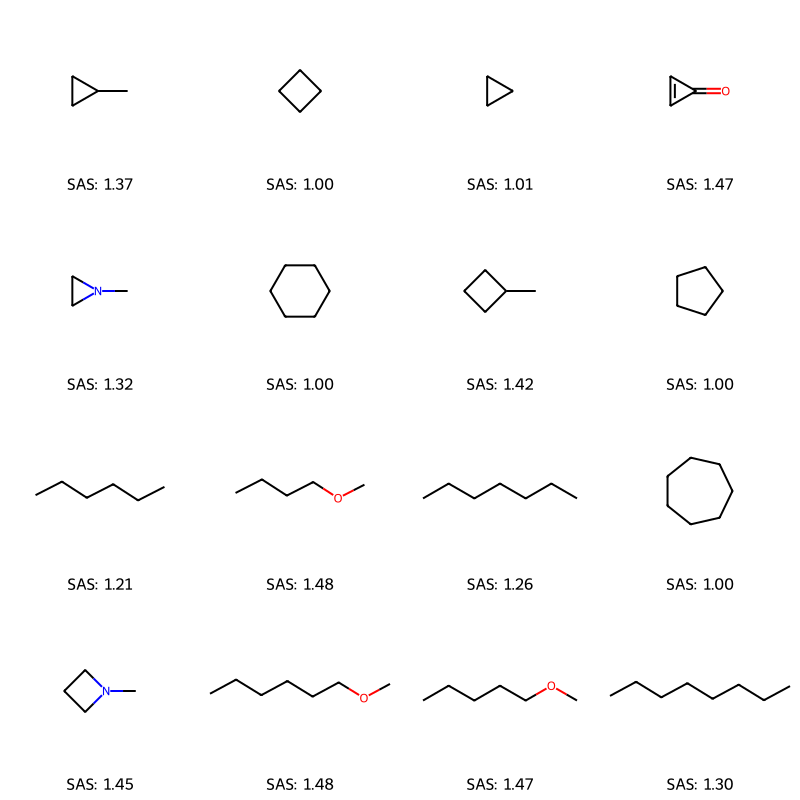

In [32]:
# Convert the unique SMILES to list
unique_smiles = list(unique_smiles)
print(unique_smiles)
# Sort the generated molecules by synthetic accessibility score
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in unique_smiles[:16]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in unique_smiles[:16]])